# Setup

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

In [2]:
import matplotlib.cm as cm

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from ml import np
from ml.rbms import RBM

In [5]:
def sample_rbm(rbm, n, initial, burnin=1000, sample_ever=10, sampler='cd', sample_every=10, **sampler_kwargs):
    v = initial
    
    for i in range(burnin):
        if sampler == 'pt':
            v, h = rbm.parallel_tempering(v, **sampler_kwargs)
        elif sampler.lower() == 'pcd':
            _, _, v, h = rbm.contrastive_divergence(v, **sampler_kwargs)
        else:
            _, _, v, h = rbm.contrastive_divergence(v, persistent=True, **sampler_kwargs)
    if sampler == 'pt':
        visibles = np.zeros((n, v[0].shape[1]))
        hiddens = np.zeros((n, h[0].shape[1]))
    else:
        visibles = np.zeros((n, v.shape[1]))
        hiddens = np.zeros((n, h.shape[1]))
    for i in range(n * sample_every):
        if sampler == 'pt':
            v, h = rbm.parallel_tempering(v, **sampler_kwargs)
        elif sampler.lower() == 'pcd':
            _, _, v, h = rbm.contrastive_divergence(v, **sampler_kwargs)
        else:
            _, _, v, h = rbm.contrastive_divergence(v, persistent=True, **sampler_kwargs)
        
        if i % sample_every == 0:
            if sampler == 'pt':
                visibles[i // sample_every] = v[0]
                hiddens[i // sample_every] = h[0]
            else:
                visibles[i // sample_every] = v
                hiddens[i // sample_every] = h
        
    return visibles, hiddens

In [6]:
def gibbs_sample_rbm(rbm, n, initial, burnin=1000, sample_every=10):
    v = initial
    h = rbm.sample_hidden(v)
    for i in range(burnin):
        v = rbm.sample_visible(h)
        h = rbm.sample_hidden(v)
        
    visibles = np.zeros((n, v.shape[0]))
    hiddens = np.zeros((n, h.shape[0]))
    for i in range(n * sample_every):
        v = rbm.sample_visible(h)
        h = rbm.sample_hidden(v)
        if i % sample_every == 0:
            visibles[i // sample_every] = rbm.sample_visible(h)
            hiddens[i // sample_every] = rbm.sample_hidden(v)
        
    return visibles, hiddens

In [7]:
def plot_gaussian_mixtures(data, samples_v, title=None, include_means=False):
    fig, axes = plt.subplots(data.shape[1], 1, figsize=(15, 16), sharex=True, sharey=True)
    
    if title is not None:
        fig.suptitle(title, fontsize='x-large')

    for j in range(data.shape[1]):
        axes[j].hist(samples_v[:, j], alpha=0.5, bins=100, density=True, label=f"{j} fake")
        axes[j].hist(data[:, j], alpha=0.5, bins=100, density=True, label=f"{j} real")
        if include_means:
            axes[j].vlines(np.mean(samples_v[:, j]), ymin=0, ymax=0.5)
            axes[j].vlines(np.mean(data[:, j]), ymin=0, ymax=0.1, color='g', linewidth=5, alpha=0.7)
        axes[j].legend()
        axes[j].set_xlim(-5, 15)
        
    return fig, axes

# Toy-problems

## Multivariate Gaussian

In [8]:
!mkdir -p runs/test

In [9]:
!ls runs

test


In [10]:
!rm runs/test/*

rm: cannot remove 'runs/test/*': No such file or directory


In [8]:
visible_size = 6
hidden_size = 6

In [9]:
means = np.arange(visible_size) + np.random.random(size=visible_size) * 3.0

In [10]:
cov = np.zeros((visible_size, visible_size))
for i in range(visible_size):
    cov[i, i] = 1.0
    cov[max(i - 1, 0), i] = 1.0
    cov[min(i + 1, visible_size - 1), i] = 1.0

# cov[0, 1] = cov[1, 0] = 0.8
# cov[5, 4] = cov[4, 5] = -0.5
# cov[5, 5] = 3.0
    
cov = np.matmul(cov, cov)

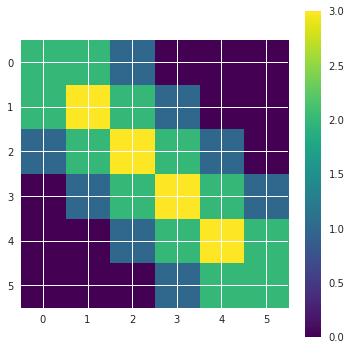

In [11]:
fig = plt.figure(figsize=cov.shape)
coloraxes = plt.imshow(cov, cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

In [12]:
data = np.random.multivariate_normal(means, np.matmul(cov, cov) , size=100000)

In [13]:
train_data, test_data = train_test_split(data)

In [14]:
from ml.rbms.core import RBM

In [15]:
# Training parameters
LR = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10
K = 1

V_SIGMA = 0.1

### Contrastive Divergence

In [38]:
rbm.v_sigma

array([1.13551287, 1.18028522, 1.4425767 , 1.53532789, 1.43501758,
       1.27995572])

In [28]:
rbm = RBM(visible_size, hidden_size, 
          visible_type='gaussian', hidden_type='bernoulli',
          sampler_method="cd",
          estimate_visible_sigma=True)

In [29]:
# rbm.v_sigma = np.std(train_data, axis=0)

In [30]:
callbacks = dict(
    pre_epoch=[lambda model, epoch: model.dump(f"runs/test/{epoch:04d}_vars.pkl", 'v_bias', 'h_bias', 'W')],
    post_step=[lambda model, epoch, end: model.dump(f"runs/test/{epoch:04d}_{end:04d}_vars.pkl", 'v_bias', 'h_bias', 'W')]
)

In [31]:
stats = rbm.fit(
    train_data, 
    k=K, 
    batch_size=BATCH_SIZE, 
    num_epochs=NUM_EPOCHS * 10, 
    learning_rate=LR,
    test_data=test_data,
#     callbacks=callbacks
)

2018-09-12 21:21:35,363 INFO      core: [001 / 100] NLL (train):            100.54889
2018-09-12 21:21:35,370 INFO      core: [001 / 100] NLL (test):             100.88571
100%|██████████| 75000/75000 [00:00<00:00, 151758.01it/s]
2018-09-12 21:21:35,867 INFO      core: [001 / 100] Reconstruction error: 26.36716871412635
2018-09-12 21:21:35,868 INFO      core: [001 / 100] Loss: 0.05567309844542126
2018-09-12 21:21:35,888 INFO      core: [002 / 100] NLL (train):             -5.93929
2018-09-12 21:21:35,893 INFO      core: [002 / 100] NLL (test):              -5.86582
100%|██████████| 75000/75000 [00:00<00:00, 143884.10it/s]
2018-09-12 21:21:36,419 INFO      core: [002 / 100] Reconstruction error: 25.068971801919503
2018-09-12 21:21:36,420 INFO      core: [002 / 100] Loss: 0.011502673684833733
2018-09-12 21:21:36,446 INFO      core: [003 / 100] NLL (train):             -8.95883
2018-09-12 21:21:36,454 INFO      core: [003 / 100] NLL (test):              -8.87863
100%|██████████| 75000/750

100%|██████████| 75000/75000 [00:00<00:00, 150834.17it/s]
2018-09-12 21:21:47,382 INFO      core: [021 / 100] Reconstruction error: 24.443117618110474
2018-09-12 21:21:47,382 INFO      core: [021 / 100] Loss: 0.008198275916648205
2018-09-12 21:21:47,400 INFO      core: [022 / 100] NLL (train):            -10.50115
2018-09-12 21:21:47,407 INFO      core: [022 / 100] NLL (test):             -10.41653
100%|██████████| 75000/75000 [00:00<00:00, 155644.43it/s]
2018-09-12 21:21:47,893 INFO      core: [022 / 100] Reconstruction error: 24.411658270885802
2018-09-12 21:21:47,894 INFO      core: [022 / 100] Loss: 0.008182615610870312
2018-09-12 21:21:47,914 INFO      core: [023 / 100] NLL (train):            -10.36800
2018-09-12 21:21:47,920 INFO      core: [023 / 100] NLL (test):             -10.28346
100%|██████████| 75000/75000 [00:00<00:00, 154384.81it/s]
2018-09-12 21:21:48,410 INFO      core: [023 / 100] Reconstruction error: 24.366399754539785
2018-09-12 21:21:48,411 INFO      core: [023 

2018-09-12 21:21:57,659 INFO      core: [042 / 100] NLL (train):            -12.26914
2018-09-12 21:21:57,665 INFO      core: [042 / 100] NLL (test):             -12.16002
100%|██████████| 75000/75000 [00:00<00:00, 157929.17it/s]
2018-09-12 21:21:58,146 INFO      core: [042 / 100] Reconstruction error: 22.912672099052333
2018-09-12 21:21:58,146 INFO      core: [042 / 100] Loss: 0.009360212685159942
2018-09-12 21:21:58,170 INFO      core: [043 / 100] NLL (train):            -12.31005
2018-09-12 21:21:58,177 INFO      core: [043 / 100] NLL (test):             -12.19797
100%|██████████| 75000/75000 [00:00<00:00, 151146.89it/s]
2018-09-12 21:21:58,677 INFO      core: [043 / 100] Reconstruction error: 22.810944666259314
2018-09-12 21:21:58,678 INFO      core: [043 / 100] Loss: 0.009489221952667487
2018-09-12 21:21:58,698 INFO      core: [044 / 100] NLL (train):            -12.51847
2018-09-12 21:21:58,703 INFO      core: [044 / 100] NLL (test):             -12.40471
100%|██████████| 75000/7

100%|██████████| 75000/75000 [00:00<00:00, 155794.43it/s]
2018-09-12 21:22:08,564 INFO      core: [062 / 100] Reconstruction error: 22.05017800967537
2018-09-12 21:22:08,564 INFO      core: [062 / 100] Loss: 0.012305443349166858
2018-09-12 21:22:08,584 INFO      core: [063 / 100] NLL (train):            -12.20117
2018-09-12 21:22:08,592 INFO      core: [063 / 100] NLL (test):             -12.02696
100%|██████████| 75000/75000 [00:00<00:00, 153799.38it/s]
2018-09-12 21:22:09,086 INFO      core: [063 / 100] Reconstruction error: 22.0476630176644
2018-09-12 21:22:09,087 INFO      core: [063 / 100] Loss: 0.012006738787939899
2018-09-12 21:22:09,104 INFO      core: [064 / 100] NLL (train):            -12.24449
2018-09-12 21:22:09,111 INFO      core: [064 / 100] NLL (test):             -12.06948
100%|██████████| 75000/75000 [00:00<00:00, 157721.63it/s]
2018-09-12 21:22:09,589 INFO      core: [064 / 100] Reconstruction error: 22.050285525448015
2018-09-12 21:22:09,590 INFO      core: [064 / 1

2018-09-12 21:22:18,978 INFO      core: [083 / 100] NLL (train):            -11.07841
2018-09-12 21:22:18,984 INFO      core: [083 / 100] NLL (test):             -10.87559
100%|██████████| 75000/75000 [00:00<00:00, 156602.75it/s]
2018-09-12 21:22:19,472 INFO      core: [083 / 100] Reconstruction error: 21.76748289149193
2018-09-12 21:22:19,473 INFO      core: [083 / 100] Loss: 0.014010853075124617
2018-09-12 21:22:19,493 INFO      core: [084 / 100] NLL (train):            -11.20760
2018-09-12 21:22:19,499 INFO      core: [084 / 100] NLL (test):             -11.00340
100%|██████████| 75000/75000 [00:00<00:00, 156277.08it/s]
2018-09-12 21:22:19,982 INFO      core: [084 / 100] Reconstruction error: 21.73484635060722
2018-09-12 21:22:19,982 INFO      core: [084 / 100] Loss: 0.01417501152836213
2018-09-12 21:22:20,001 INFO      core: [085 / 100] NLL (train):            -11.20052
2018-09-12 21:22:20,010 INFO      core: [085 / 100] NLL (test):             -10.99466
100%|██████████| 75000/7500

In [32]:
!ls runs/test

In [33]:
list(stats.keys())

['nll_train', 'nll_test', 'reconstruction_error', 'loss']

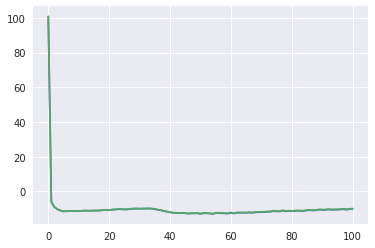

In [34]:
plt.plot(stats['nll_train'])
plt.plot(stats['nll_test'])

In [35]:
samples_v, samples_h = gibbs_sample_rbm(rbm, 100000, data[123], burnin=10000)

(<Figure size 1080x1152 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d2b816128>,
       dtype=object))

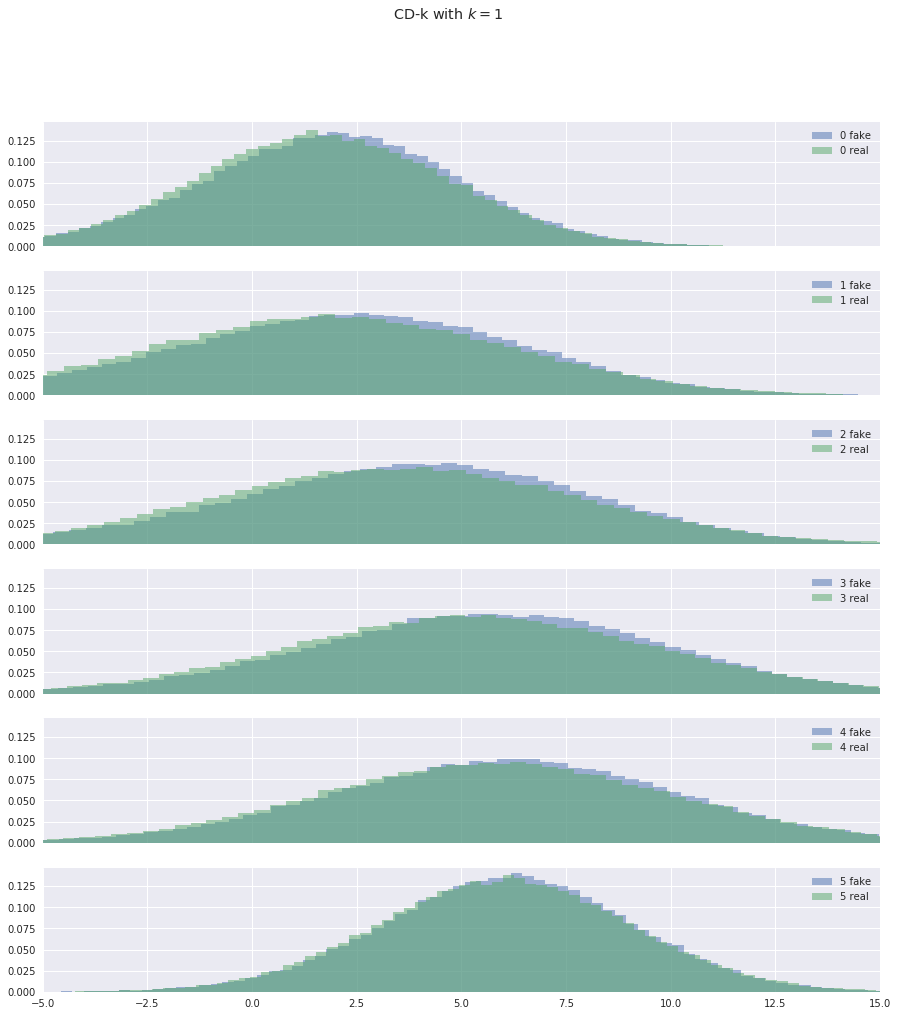

In [36]:
plot_gaussian_mixtures(data, samples_v, title=f"CD-k with $k={K}$")

In [39]:
v = data

np.mean(np.abs(np.sum(np.matmul(v, rbm.W), axis=1)))

107.53153203538592

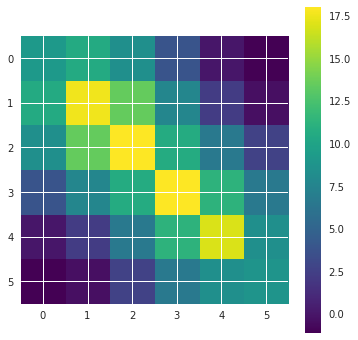

In [40]:
im = np.cov(np.round(samples_v), rowvar=False)

fig = plt.figure(figsize=im.shape)
coloraxes = plt.imshow(im, cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

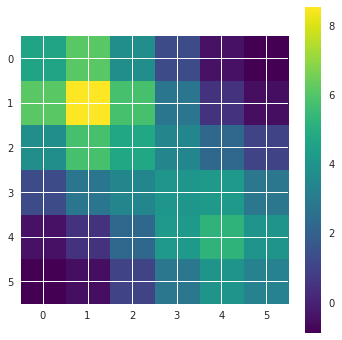

In [41]:
fig = plt.figure(figsize=(visible_size, visible_size))
coloraxes = plt.imshow(np.matmul(rbm.W, rbm.W.T), cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

### Weights through time

In [ ]:
import os
import glob

In [ ]:
# [os.remove(p) for p in glob.glob("runs/test/00*_*_vars.pkl")]

In [ ]:
import pickle

def load(p):
    with open(p, "rb") as f:
        return pickle.load(f)

In [ ]:
import time
from IPython import display

fig, axes = plt.subplots(1, 4, figsize=(10 + 6 + 10, 20))

# load weights
history = (load(p) for p in sorted(glob.glob("runs/test/00*_*_vars.pkl")))
i = 0
for h in history:
#     print(i)
    i += 1
    if i % 50 != 0:
        continue
    W = h['W']
    fig.suptitle(i)
    axes[0].imshow(np.matmul(W, W.T), cmap=cm.viridis)
    axes[1].imshow(h['v_bias'].reshape(-1, 1), cmap=cm.viridis)
    axes[2].imshow(h['h_bias'].reshape(-1, 1), cmap=cm.viridis)
    axes[3].imshow(np.matmul(W.T, W), cmap=cm.viridis)
#     plt.colorbar(coloraxes)
#     cbar = fig.colorbar(coloraxes)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

### Parallel Tempering

In [40]:
rbm = RBM(visible_size, hidden_size, 
          visible_type='gaussian', hidden_type='bernoulli',
          sampler_method="pt",
          estimate_visible_sigma=True)

In [28]:
# rbm.v_sigma = np.var(train_data, axis=0)

In [41]:
train_nll, test_nll = rbm.fit(
    train_data, 
    k=K, 
    batch_size=BATCH_SIZE, 
    num_epochs=NUM_EPOCHS * 10, 
    learning_rate=LR,
    test_data=test_data,
    persist=True,
#     callbacks=callbacks
)

2018-09-14 08:39:45,269 INFO      core: [001 / 100] NLL (train):            100.13801
2018-09-14 08:39:45,274 INFO      core: [001 / 100] NLL (test):             100.17770



  0%|          | 0/75000 [00:00<?, ?it/s]2018-09-14 08:39:45,278 INFO      core: Initializing PT chain...
2018-09-14 08:39:45,285 WARNING   core: Large portion of tempered samples accepted (128 / 128)
2018-09-14 08:39:45,294 WARNING   core: Large portion of tempered samples accepted (128 / 128)
2018-09-14 08:39:45,301 WARNING   core: Large portion of tempered samples accepted (128 / 128)
2018-09-14 08:39:45,312 WARNING   core: Large portion of tempered samples accepted (128 / 128)
2018-09-14 08:39:45,318 WARNING   core: Large portion of tempered samples accepted (127 / 128)
2018-09-14 08:39:45,325 WARNING   core: Large portion of tempered samples accepted (128 / 128)
2018-09-14 08:39:45,333 WARNING   core: Large portion of tempered samples accepted (128 / 128)
2018-09-14 08:39:45,341 WARNING   core: Large portion 

2018-09-14 08:39:53,329 INFO      core: [003 / 100] Loss:                    inf
2018-09-14 08:39:53,348 INFO      core: [004 / 100] NLL (train):             -4.13792
2018-09-14 08:39:53,357 INFO      core: [004 / 100] NLL (test):              -4.13778



  0%|          | 0/75000 [00:00<?, ?it/s]


  3%|▎         | 2432/75000 [00:00<00:03, 24011.80it/s]


  7%|▋         | 5248/75000 [00:00<00:02, 25106.72it/s]


 11%|█         | 8320/75000 [00:00<00:02, 26439.58it/s]


 15%|█▌        | 11520/75000 [00:00<00:02, 27822.57it/s]


 19%|█▉        | 14464/75000 [00:00<00:02, 28186.22it/s]


 23%|██▎       | 17536/75000 [00:00<00:02, 28696.59it/s]


 27%|██▋       | 20480/75000 [00:00<00:01, 28654.98it/s]


 32%|███▏      | 23680/75000 [00:00<00:01, 29281.06it/s]


 36%|███▌      | 27136/75000 [00:00<00:01, 30577.91it/s]


 40%|████      | 30208/75000 [00:01<00:01, 30121.72it/s]


 44%|████▍     | 33280/75000 [00:01<00:01, 29481.97it/s]


 48%|████▊     | 36224/75000 [00:01<00:01, 29370.14it/

KeyboardInterrupt: 

In [23]:
plt.plot(train_nll)
plt.plot(test_nll)

NameError: name 'train_nll' is not defined

In [38]:
samples_v, samples_h = gibbs_sample_rbm(rbm, 10000, data[123], burnin=1000)

(<Figure size 1080x1152 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2540977f60>,
       dtype=object))

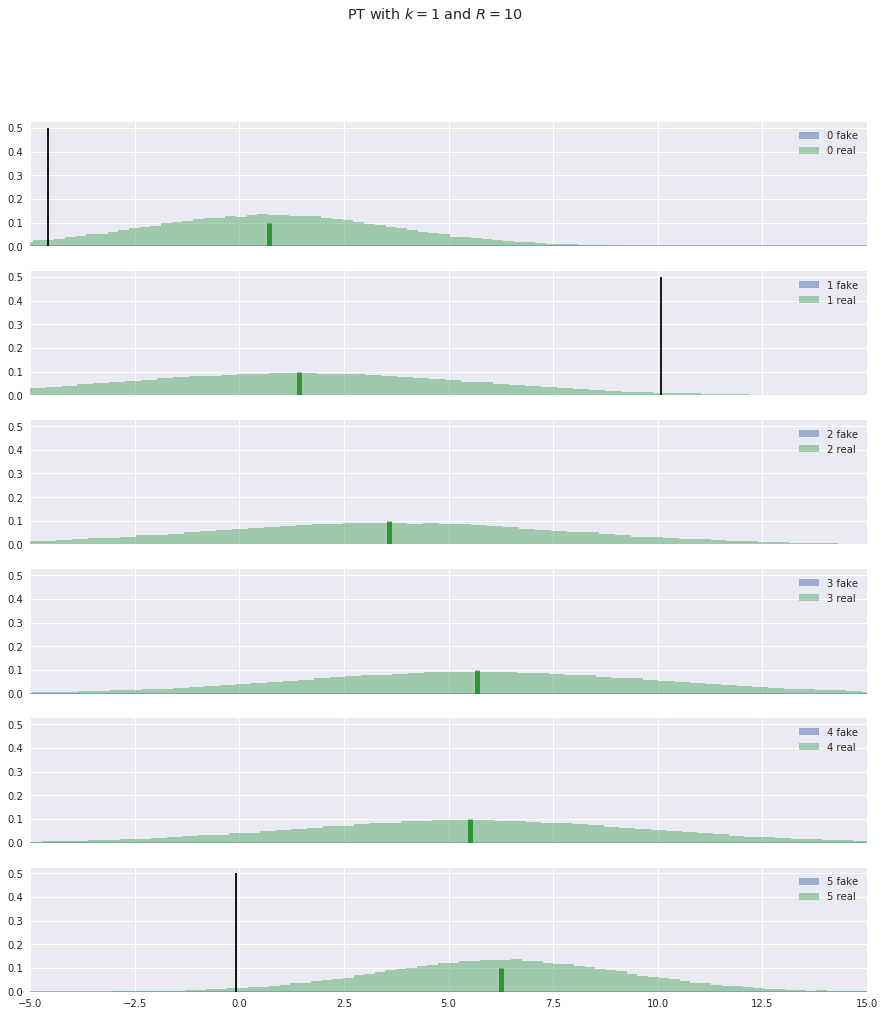

In [39]:
plot_gaussian_mixtures(data, samples_v, title="PT with $k = 1$ and $R = 10$", include_means=True)

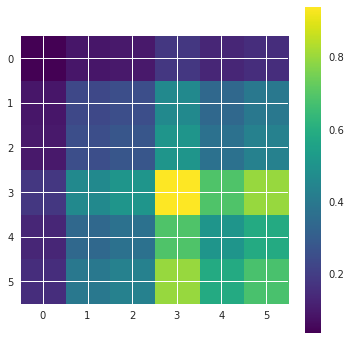

In [45]:
im = np.matmul(rbm.W, rbm.W.T)

fig = plt.figure(figsize=im.shape)
coloraxes = plt.imshow(im, cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

# 1D Ising

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv("data/ising_binary_1d.csv", skiprows=1)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
data = df.values.astype(np.float64)

In [12]:
# data += np.random.normal(scale=0.1, size=data.shape)

In [13]:
train_data, test_data = train_test_split(data)

In [14]:
LR = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 10
K = 1

V_SIGMA = 0.1

In [15]:
visible_size = 6
hidden_size = 6

## Model

In [16]:
rbm_cd = RBM(visible_size, hidden_size, 
          visible_type='gaussian', hidden_type='bernoulli',
          sampler_method="cd",
          estimate_visible_sigma=False)

rbm_cd.v_sigma = V_SIGMA

In [18]:
train_nll, test_nll = rbm_cd.fit(
    train_data, 
    k=K, 
    batch_size=BATCH_SIZE, 
    num_epochs=NUM_EPOCHS, 
    learning_rate=LR,
    test_data=test_data,
#     reset_per_epoch=True,
#     burnin=1000,
#     persist=True
)

2018-07-20 00:56:12,019 INFO      core: [001 / 010] NLL (train):            146.51349
2018-07-20 00:56:12,040 INFO      core: [001 / 010] NLL (test):             146.20800
100%|██████████| 374999/374999 [00:02<00:00, 165027.43it/s]
2018-07-20 00:56:14,326 INFO      core: [001 / 010] Reconstruction error: 2.4501362453788538
2018-07-20 00:56:14,326 INFO      core: [001 / 010] Loss: 0.3352582602464678
2018-07-20 00:56:14,392 INFO      core: [002 / 010] NLL (train):             33.44885
2018-07-20 00:56:14,411 INFO      core: [002 / 010] NLL (test):              33.50399
100%|██████████| 374999/374999 [00:02<00:00, 165362.69it/s]
2018-07-20 00:56:16,690 INFO      core: [002 / 010] Reconstruction error: 2.350981348789084
2018-07-20 00:56:16,691 INFO      core: [002 / 010] Loss: 0.21674627818071773
2018-07-20 00:56:16,747 INFO      core: [003 / 010] NLL (train):             34.53367
2018-07-20 00:56:16,769 INFO      core: [003 / 010] NLL (test):              34.55563
100%|██████████| 374999/

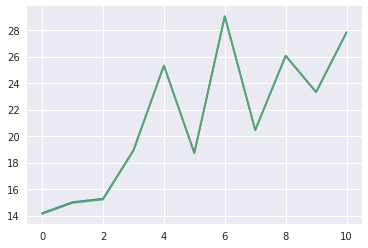

In [38]:
plt.plot(train_nll)
plt.plot(test_nll)

In [19]:
train_test_split?

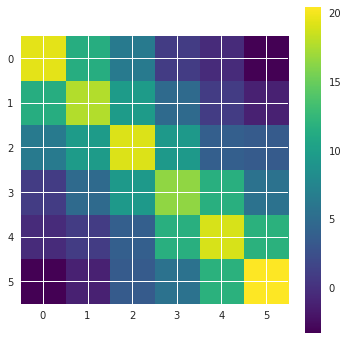

In [39]:
fig = plt.figure(figsize=(visible_size, visible_size))
coloraxes = plt.imshow(np.matmul(rbm_cd.W, rbm_cd.W.T), cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

### Sample

In [40]:
num_samples = 20000
burnin = 2000
sample_every = 10

In [41]:
samples_v, samples_h = gibbs_sample_rbm(rbm_cd, num_samples, test_data[0], burnin=burnin, sample_every=sample_every)

In [49]:
v = test_data[0].reshape(1, -1)
betas = [1.0, 0.5, 0.25, 0.1]
v_pt = np.tile(v, (len(betas), 1, 1))

samples_v_pt, samples_h_pt = sample_rbm(
    rbm_cd, num_samples, 
    v_pt, 
    burnin=burnin, 
    sample_every=sample_every,
    sampler='pt',
    k=1,
    betas=betas
#     betas=np.linspace(0.0, 1.0, 2 * K + 1)[::-1][:-1] # drop 0.0
#     num_temps=10, max_temp=1000
)

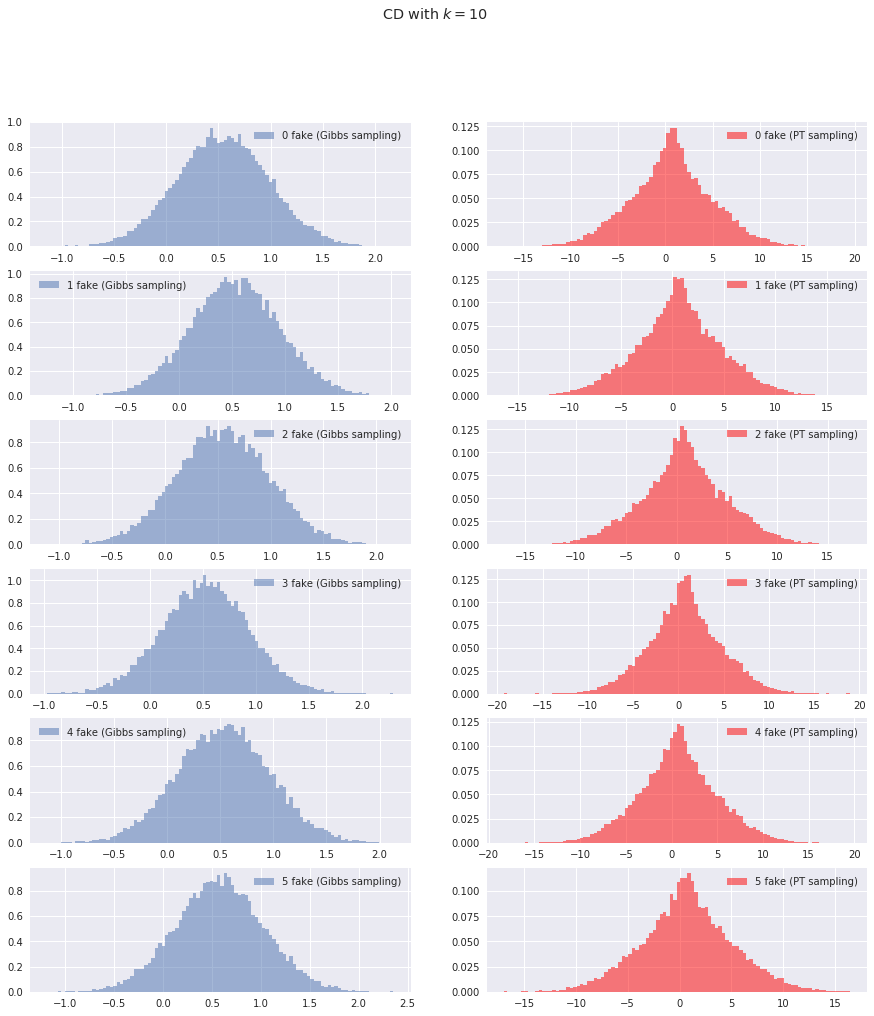

In [50]:
fig, axes = plt.subplots(data.shape[1], 2, figsize=(15, 16), sharex=False, sharey=False)

fig.suptitle("CD with $k = 10$", fontsize='x-large')

for j in range(data.shape[1]):
    axes[j][0].hist(samples_v[:, j], alpha=0.5, bins=100, density=True, label=f"{j} fake (Gibbs sampling)")
    axes[j][1].hist(samples_v_pt[:, j], alpha=0.5, bins=100, density=True, color='red', label=f"{j} fake (PT sampling)")
#     axes[j][0].hist(data[:, j], alpha=0.5, bins=100, density=True, label=f"{j} real")
#     axes[j].vlines(np.mean(samples_v[:, j]), ymin=0, ymax=0.5)
#     axes[j].vlines(np.mean(data[:, j]), ymin=0, ymax=0.1, color='g', linewidth=5, alpha=0.7)
    axes[j][0].legend()
    axes[j][1].legend()
#     axes[j].set_xlim(-5, 15)

plt.savefig("gibbs_and_pt_sampling_1d_ising_samples_200000_every_100_burnin_20000.png")

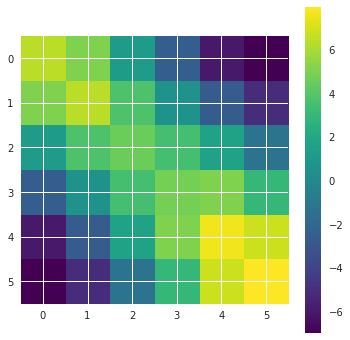

In [76]:
fig = plt.figure(figsize=(visible_size, visible_size))
coloraxes = plt.imshow(np.matmul(rbm_cd.W, rbm_cd.W.T), cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

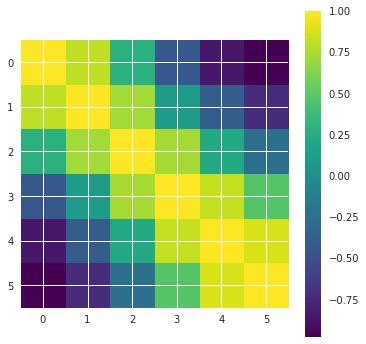

In [27]:
fig = plt.figure(figsize=(visible_size, visible_size))
coloraxes = plt.imshow(np.corrcoef(samples_v, rowvar=False), cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

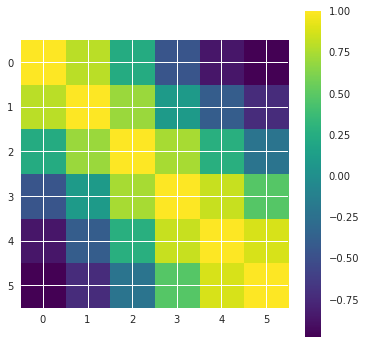

In [28]:
fig = plt.figure(figsize=(visible_size, visible_size))
coloraxes = plt.imshow(np.corrcoef(samples_v_pt, rowvar=False), cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

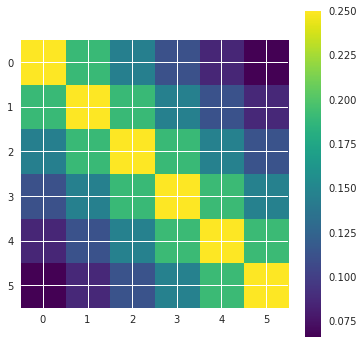

In [24]:
im = np.cov(data, rowvar=False)

fig = plt.figure(figsize=im.shape)
coloraxes = plt.imshow(im, cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

### Parallel Tempering

In [21]:
rbm = RBM(visible_size, hidden_size, 
          visible_type='bernoulli', hidden_type='gaussian',
          sampler_method="pt",
          estimate_visible_sigma=False)

In [22]:
rbm.v_sigma = V_SIGMA

In [23]:
train_nll, test_nll = rbm.fit(
    train_data,
    batch_size=BATCH_SIZE, 
    num_epochs=NUM_EPOCHS, 
    learning_rate=LR * 0.1,  # use smaller learning-rate when using PT
    test_data=test_data,
    k=1,
    num_temps=K,  # k = 1 per temp, but use K temps
    max_temp=1000,
)

2018-07-08 23:54:49,270 INFO      core: [001 / 010] NLL (train):       -1033906.82831
2018-07-08 23:54:49,283 INFO      core: [001 / 010] NLL (test):         -344636.48421
100%|██████████| 374999/374999 [00:07<00:00, 47739.56it/s]
2018-07-08 23:54:57,190 INFO      core: [002 / 010] NLL (train):       -1045372.33832
2018-07-08 23:54:57,202 INFO      core: [002 / 010] NLL (test):         -348458.71542
100%|██████████| 374999/374999 [00:07<00:00, 48842.08it/s]
2018-07-08 23:55:04,927 INFO      core: [003 / 010] NLL (train):       -1376714.68205
2018-07-08 23:55:04,942 INFO      core: [003 / 010] NLL (test):         -458871.52285
100%|██████████| 374999/374999 [00:07<00:00, 49492.90it/s]
2018-07-08 23:55:12,567 INFO      core: [004 / 010] NLL (train):      -12372189.35679
2018-07-08 23:55:12,579 INFO      core: [004 / 010] NLL (test):        -4122739.10885
100%|██████████| 374999/374999 [00:07<00:00, 49402.91it/s]
2018-07-08 23:55:20,217 INFO      core: [005 / 010] NLL (train):      -80893

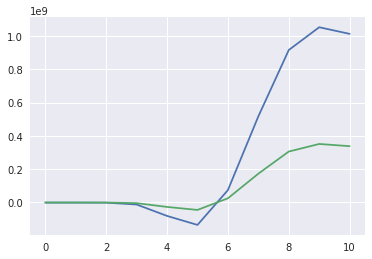

In [24]:
plt.plot(train_nll)
plt.plot(test_nll)

#### Sample

In [25]:
samples_v, samples_h = gibbs_sample_rbm(rbm, 100000, test_data[0], burnin=10000, sample_every=1)

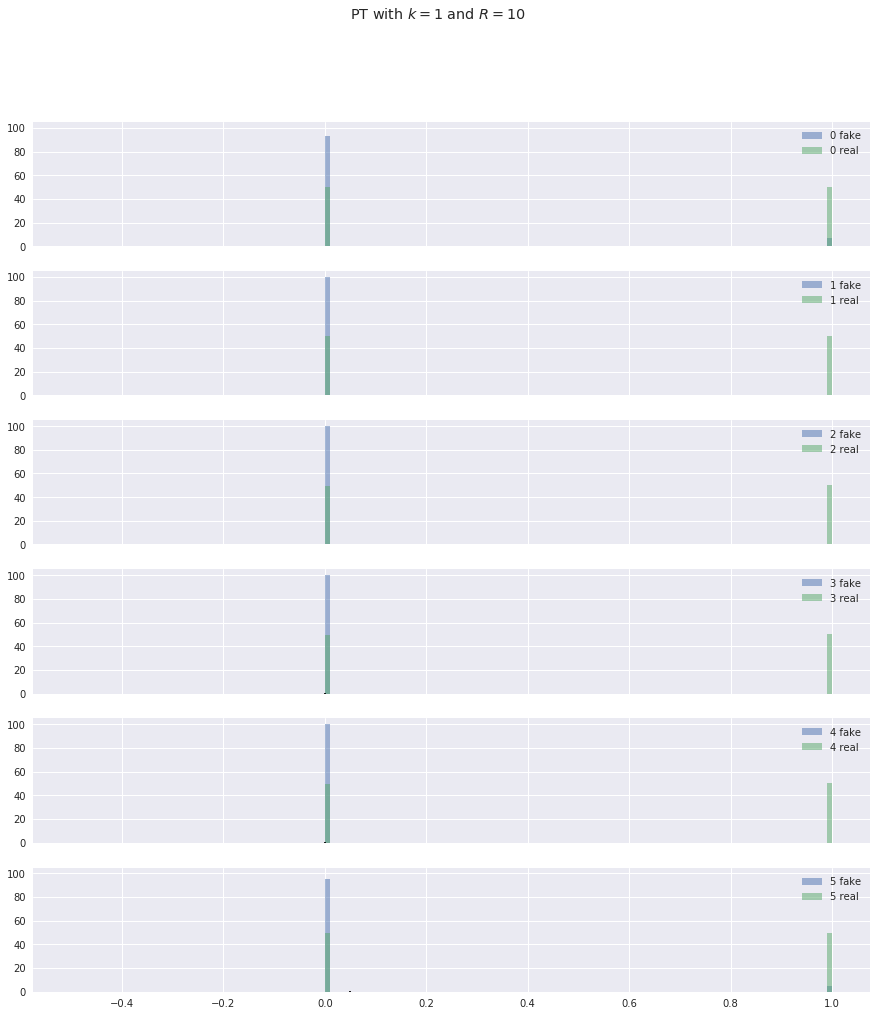

In [26]:
fig, axes = plt.subplots(data.shape[1], 1, figsize=(15, 16), sharex=True, sharey=True)

fig.suptitle("PT with $k = 1$ and $R = 10$", fontsize='x-large')

for j in range(data.shape[1]):
    axes[j].hist(samples_v[:, j], alpha=0.5, bins=100, density=True, label=f"{j} fake")
    axes[j].hist(data[:, j], alpha=0.5, bins=100, density=True, label=f"{j} real")
    axes[j].vlines(np.mean(samples_v[:, j]), ymin=0, ymax=0.5)
#     axes[j].vlines(np.mean(data[:, j]), ymin=0, ymax=0.1, color='g', linewidth=5, alpha=0.7)
    axes[j].legend()
#     axes[j].set_xlim(-5, 15)

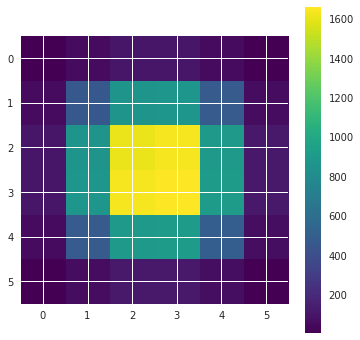

In [27]:
fig = plt.figure(figsize=(visible_size, visible_size))
coloraxes = plt.imshow(np.matmul(rbm.W, rbm.W.T), cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

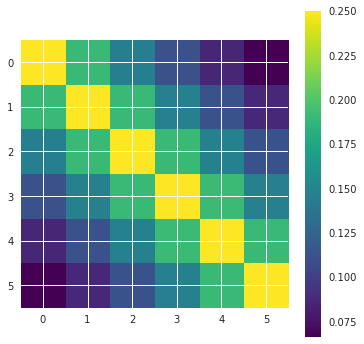

In [28]:
fig = plt.figure(figsize=(visible_size, visible_size))
coloraxes = plt.imshow(np.cov(train_data, rowvar=False), cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)

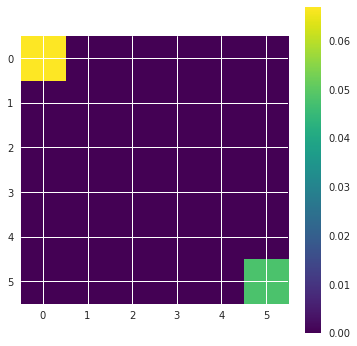

In [29]:
fig = plt.figure(figsize=(visible_size, visible_size))
coloraxes = plt.imshow(np.cov(samples_v, rowvar=False), cmap=cm.viridis)
cbar = fig.colorbar(coloraxes)